Handout: Explaining Clusters - example
    <ol>
    <li>Goal</li>
    You clustered your dataset (e.g. patient samples). Now: which features define each cluster?
    <li>Workflow</li>
        <ol>
        <li>Summarize features by cluster</li>
            <ul>
                <li>Continuous: mean, std, median.</li>
            </ul>
            <ul>
                <li>Binary: counts, proportions.</li>
            </ul>
        <li>Test differences</li>
            <ul>
                <li>Continuous → ANOVA/Kruskal-Wallis + Cohen’s d effect size.</li>
            </ul>
            <ul>
                <li>Binary → Chi-square/Fisher + difference in proportions.</li>
            </ul>
            <ul>
                <li>Adjust p-values (Benjamini–Hochberg).</li>
            </ul>
        <li>Multivariate check</li>
            <ul>
                <li>Train a Random Forest (or logistic regression) to predict cluster labels.</li>
            </ul>
            <ul>
                <li>Look at feature importance (permutation / SHAP).</li>
            </ul>
        <li>Interpret clusters</li>
            <ul>
                <li>Combine univariate + multivariate evidence.</li>
            </ul>
            <ul>
                <li>Example: Cluster 2 = high BMI, high diabetes prevalence, older patients.</li>
            </ul>
        <li>Visualize</li>
            <ul>
                <li>Heatmap of feature means per cluster (or Heatmap of sample features, after reordering samples
            by cluster).</li>
            </ul>
            <ul>
                <li>Boxplots for key continuous vars</li>
            </ul>
            <ul>
                <li>Bar plots for binary vars.</li>
            </ul>
            <ul>
                <li>UMAP/t-SNE scatter colored by features.</li>
            </ul>
        </ol>
    </ol>

In [ ]:
import pandas as pd
import numpy as np

#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

from scipy.stats import f_oneway, kruskal, chi2_contingency
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import silhouette_score

In [5]:
df = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')
df.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

Normalization and clustering

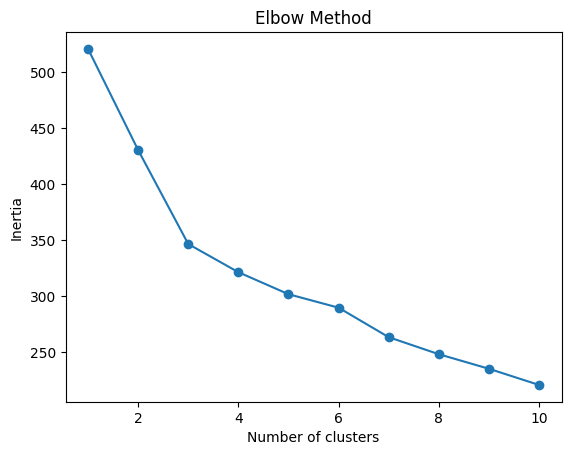

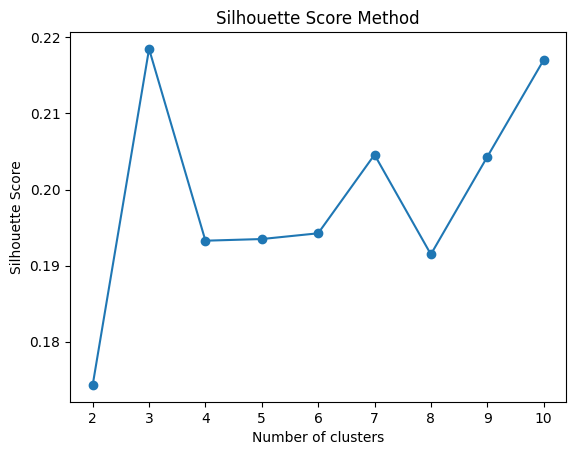

In [ ]:
# Let's separate the features
X = df.copy()

continuous_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
binary_vars = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']

# Standardization
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# elbow method to find optimal number of clusters
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# silhouette score to find optimal number of clusters
silhouette_scores = []
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

# Clustering (K-Means)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Adding clusters to the dataframe
df['cluster'] = clusters


In [37]:
# Summarize features by cluster
# Continuous: mean, std, median.
# Binary: counts, proportions.

summary = {}
for col in X.columns:
    if col in continuous_vars:
        summary[col] = df.groupby('cluster')[col].agg(['mean', 'std', 'median']).reset_index()
    elif col in binary_vars:
        summary[col] = df.groupby('cluster')[col].agg(['sum', 'count']).reset_index()
        summary[col]['proportion'] = summary[col]['sum'] / summary[col]['count']
# Display summary statistics
for col, stats in summary.items():
    print(f"Feature: {col}")
    print(stats)
    print("-" * 40)

Feature: age
   cluster       mean        std  median
0        0  59.534653  10.946748    60.0
1        1  58.297225  10.486290    60.0
2        2  66.418808  13.347873    65.0
----------------------------------------
Feature: anaemia
   cluster  sum  count  proportion
0        0   37    101    0.366337
1        1   58    120    0.483333
2        2   34     78    0.435897
----------------------------------------
Feature: creatinine_phosphokinase
   cluster        mean          std  median
0        0  583.950495   901.029882   224.0
1        1  533.125000   659.264851   299.5
2        2  654.051282  1381.492820   259.0
----------------------------------------
Feature: diabetes
   cluster  sum  count  proportion
0        0   18    101    0.178218
1        1   85    120    0.708333
2        2   22     78    0.282051
----------------------------------------
Feature: ejection_fraction
   cluster       mean        std  median
0        0  39.534653  10.451377    38.0
1        1  40.175000  11

Univariate analysis: differences between clusters

Continuous variables → ANOVA / Kruskal

In [ ]:
#continuous_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
results = []

for var in continuous_vars:
    groups = [df[df['cluster'] == c][var] for c in df['cluster'].unique()]
    stat, p = f_oneway(*groups)  # oppure kruskal(*groups)
    results.append({'variable': var, 'p_value': p})

res_df = pd.DataFrame(results)
res_df.sort_values('p_value')

variable       p_value
6                      time  8.171895e-16
0                       age  4.329118e-06
2         ejection_fraction  3.953580e-05
4          serum_creatinine  6.744797e-05
5              serum_sodium  2.003730e-02
3                 platelets  1.260529e-01
1  creatinine_phosphokinase  6.938661e-01

Binary variables → Chi-square

In [15]:
#binary_vars = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']

chi_results = []
for var in binary_vars:
    contingency = pd.crosstab(df[var], df['cluster'])
    chi2, p, _, _ = chi2_contingency(contingency)
    chi_results.append({'variable': var, 'p_value': p})

chi_df = pd.DataFrame(chi_results)
chi_df.sort_values('p_value')


variable       p_value
5          DEATH_EVENT  2.061742e-50
3                  sex  3.173357e-30
4              smoking  1.766498e-24
1             diabetes  3.174791e-16
0              anaemia  2.155811e-01
2  high_blood_pressure  6.273104e-01

Multivariate analysis (Random Forest to understand feature importance)

In [19]:
X_scaled

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    0.636364      0.0                  0.071319       0.0           0.090909   
1    0.272727      0.0                  1.000000       0.0           0.363636   
2    0.454545      0.0                  0.015693       0.0           0.090909   
3    0.181818      1.0                  0.011227       0.0           0.090909   
4    0.454545      1.0                  0.017479       1.0           0.090909   
..        ...      ...                       ...       ...                ...   
294  0.400000      0.0                  0.004848       1.0           0.363636   
295  0.272727      0.0                  0.229268       0.0           0.363636   
296  0.090909      0.0                  0.259888       1.0           0.696970   
297  0.090909      0.0                  0.304925       0.0           0.363636   
298  0.181818      0.0                  0.022072       0.0           0.469697   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1.0   0.290823          0.157303      0.485714  1.0   
1                    0.0   0.288833          0.067416      0.657143  1.0   
2                    0.0   0.165960          0.089888      0.457143  1.0   
3                    0.0   0.224148          0.157303      0.685714  1.0   
4                    0.0   0.365984          0.247191      0.085714  0.0   
..                   ...        ...               ...           ...  ...   
294                  1.0   0.157474          0.067416      0.857143  1.0   
295                  0.0   0.296884          0.078652      0.742857  0.0   
296                  0.0   0.869075          0.033708      0.714286  0.0   
297                  0.0   0.139290          0.101124      0.771429  1.0   
298                  0.0   0.448418          0.123596      0.657143  1.0   

     smoking      time  DEATH_EVENT  cluster  
0        0.0  0.000000          1.0      1.0  
1        0.0  0.007117          1.0      1.0  
2        1.0  0.010676          1.0      1.0  
3        0.0  0.010676          1.0      1.0  
4        0.0  0.014235          1.0      0.5  
..       ...       ...          ...      ...  
294      1.0  0.946619          0.0      0.0  
295      0.0  0.950178          0.0      0.5  
296      0.0  0.975089          0.0      0.5  
297      1.0  0.982206          0.0      0.0  
298      1.0  1.000000          0.0      0.0  

[299 rows x 14 columns]

In [31]:
X = X_scaled.drop(columns=['cluster'])

X_train, X_test, y_train, y_test = train_test_split(X, clusters, test_size=0.3, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

print(classification_report(y_test, rf.predict(X_test)))

# Importance with permutation importance
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({'feature': X.columns, 'importance': perm.importances_mean}).sort_values('importance', ascending=False)
importance_df

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.91      0.94      0.93        34
           2       0.93      0.93      0.93        30

    accuracy                           0.94        90
   macro avg       0.95      0.95      0.95        90
weighted avg       0.95      0.94      0.94        90



feature  importance
12               DEATH_EVENT    0.378889
9                        sex    0.184444
3                   diabetes    0.124444
10                   smoking    0.091111
1                    anaemia    0.000000
5        high_blood_pressure    0.000000
8               serum_sodium   -0.003333
0                        age   -0.004444
11                      time   -0.007778
2   creatinine_phosphokinase   -0.010000
7           serum_creatinine   -0.010000
4          ejection_fraction   -0.016667
6                  platelets   -0.017778

Removing features with negative values trying to get better results

In [35]:
features_to_drop = [
    'anaemia',
    'high_blood_pressure',
    'serum_sodium',
    'age',
    'time',
    'creatinine_phosphokinase'
]

X_reduced = X.drop(columns=features_to_drop)

X_train_new, X_test_new, y_train, y_test = train_test_split(X_reduced, clusters, test_size=0.3, random_state=42)

rf_new = RandomForestClassifier(random_state=42)

rf_new.fit(X_train_new, y_train)

print("New Classification Report (with fewer features):")
print(classification_report(y_test, rf_new.predict(X_test_new)))
perm = permutation_importance(rf_new, X_test_new, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({'feature': X_reduced.columns, 'importance': perm.importances_mean}).sort_values('importance', ascending=False)
importance_df

New Classification Report (with fewer features):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.97      1.00      0.99        34
           2       1.00      1.00      1.00        30

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90



feature  importance
6        DEATH_EVENT    0.404444
4                sex    0.211111
0           diabetes    0.143333
5            smoking    0.114444
1  ejection_fraction    0.000000
2          platelets    0.000000
3   serum_creatinine    0.000000

<b>Visualization</b>

Heatmap of cluster averages

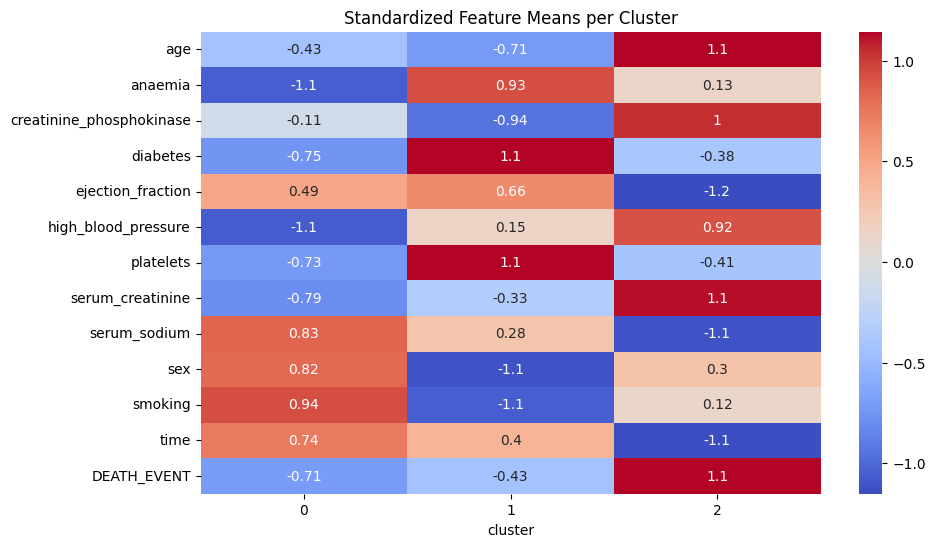

In [23]:
# Standardize the feature values (z-scores)
standardized_means = df.groupby('cluster').mean()
standardized_means = (standardized_means - standardized_means.mean()) / standardized_means.std()

# Plot the standardized heatmap
plt.figure(figsize=(10,6))
sns.heatmap(standardized_means.T, cmap='coolwarm', annot=True)
plt.title("Standardized Feature Means per Cluster")
plt.show()

Boxplots with continuous variables

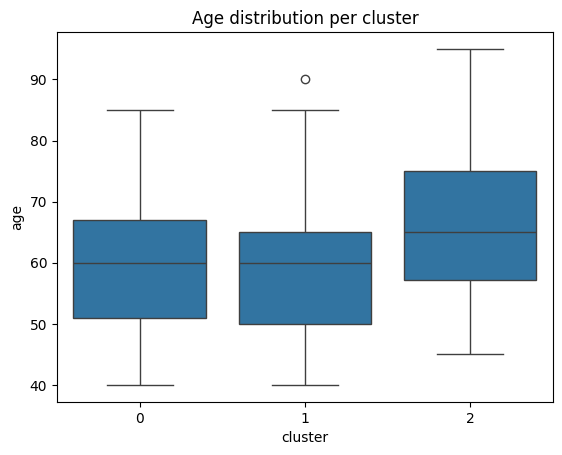

In [24]:
sns.boxplot(data=df, x='cluster', y='age')
plt.title('Age distribution per cluster')
plt.show()


Barplot for binary variables

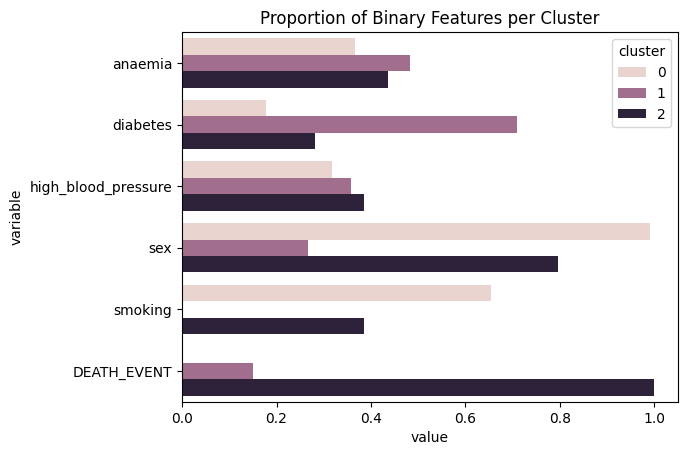

In [28]:
# Calculate the mean proportions of binary features by cluster
binary_means = df.groupby('cluster')[binary_vars].mean().reset_index()

# Melt the DataFrame to long format for seaborn compatibility
binary_means_melted = binary_means.melt(id_vars='cluster', var_name='variable', value_name='value')

# Plot the horizontal barplot
sns.barplot(data=binary_means_melted, x='value', y='variable', hue='cluster', orient='h')
plt.title('Proportion of Binary Features per Cluster')
plt.show()


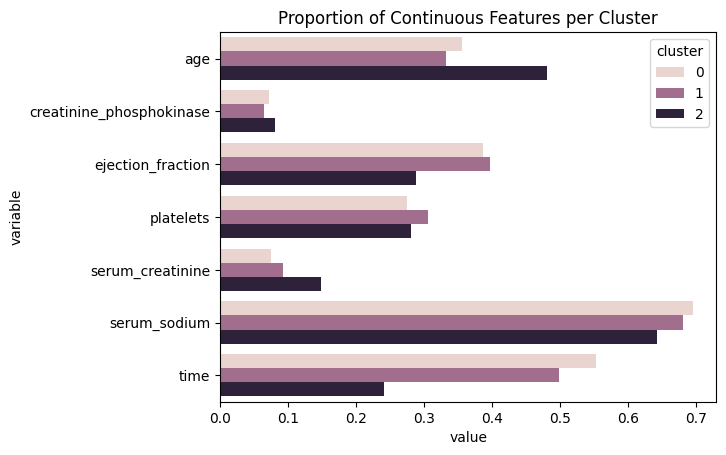

In [29]:
# Calculate the mean proportions of binary features by cluster
X_scaled['cluster'] = clusters
continuous_means = X_scaled.groupby('cluster')[continuous_vars].mean().reset_index()

# Melt the DataFrame to long format for seaborn compatibility
continuous_means_melted = continuous_means.melt(id_vars='cluster', var_name='variable', value_name='value')

# Plot the horizontal barplot
sns.barplot(data=continuous_means_melted, x='value', y='variable', hue='cluster', orient='h')
plt.title('Proportion of Continuous Features per Cluster')
plt.show()
